# Variational Autoencoder: Learning Rate Finder

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis, colorbar, imshow, show, figure, subplot
from matplotlib import cm
import matplotlib as mpl
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
%matplotlib inline

import glob

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

from time import time
from tqdm import tqdm

import cv2

import sklearn
from sklearn.model_selection import train_test_split

## ----- GPU ------------------------------------
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'    # use of GPU 0 (ERDA) (use before importing torch or tensorflow/keeas)
## ----------------------------------------------

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras.activations import relu
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K                         #contains calls for tensor manipulations

In [2]:
print (tf.__version__)
print (keras.__version__)

2.3.0
2.4.3


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Initializing

In [4]:
from utils_vae_kitkat_paths import *

# Get work directions for augmentated data set:
print ("NORMAL_TRAIN_AUG:      ", NORMAL_TRAIN_AUG)
print ("NORMAL_VALIDATION_AUG: ", NORMAL_VAL_AUG)
print ("NORMAL_TEST_AUG:       ", NORMAL_TEST_AUG)
print ("ANOMALY_AUG:           ", ANOMALY_AUG)

NORMAL_TRAIN_AUG:       /home/jovyan/work/Speciale/FoodSorting/generated_dataset/KitKatChunky//DataAugmentation/NormalTrainAugmentations
NORMAL_VALIDATION_AUG:  /home/jovyan/work/Speciale/FoodSorting/generated_dataset/KitKatChunky//DataAugmentation/NormalValidationAugmentations
NORMAL_TEST_AUG:        /home/jovyan/work/Speciale/FoodSorting/generated_dataset/KitKatChunky//DataAugmentation/NormalTestAugmentations
ANOMALY_AUG:            /home/jovyan/work/Speciale/FoodSorting/generated_dataset/KitKatChunky//DataAugmentation/AnomalyAugmentations


In [5]:
# What latent dimension and filter size are we using?:
latent_dim = 2

# Get work direction for saving files:
SAVE_FOLDER = 'saved_models/LearningRateFinder'
print ("Which Folder The Models Are Saved In:", SAVE_FOLDER)

Which Folder The Models Are Saved In: saved_models/LearningRateFinder


## Load Data


### Import Utils

In [6]:
from utils_VAE_AE import get_labels

### Quick Investigation of Ground Truths

In [7]:
# Glob the directories and get the lists of good and bad images
good_train_fns = [f for f in os.listdir(NORMAL_TRAIN_AUG) if not f.startswith('.')]

print('Number of "normal" training images is:     {}'.format(len(good_train_fns)))

Number of "normal" training images is:     1400


### Load Normal Training Data

We only need to pre-splitted training data

In [8]:
print("[INFO] loading normal training images...")
trainX = [cv2.imread(file, 0) for file in glob.glob(f"{NORMAL_TRAIN_AUG}/*.png")]  # read as grayscale
trainX = np.array(trainX)
print("          done")

# create a corresponding list of labels:
trainY = get_labels(trainX, 0)

[INFO] loading normal training images...
          done


## Feature Scaling

Only normalization has been used.

In [9]:
# Data configuration
img_width, img_height = trainX.shape[1], trainX.shape[2]      # input image dimensions
num_channels = 1                                              # gray-scaled 

### Normalization

Neural Networks learns faster with normalized data.

In [10]:
# Normalize to be in  the [0, 1] range:
trainX = trainX.astype('float32') / 255.

# reshape data to keras inputs --> (n_samples, img_rows, img_cols, n_channels):
trainX = trainX.reshape(trainX.shape[0], img_height, img_width, num_channels)

# Train the VAE

## Architecture and Hyperparameters


In [11]:
# import architecture of VAE model and its hyperparameters:
from J2_VAE_model import *

### *Encoder Part*


In [12]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        leaky_re_lu[0][0]                
____________________________________________________________________________________________

### *Decoder Part*

In [13]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0   

### *Total VAE Model*

In [14]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 140716    
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 1)       48065     
Total params: 188,781
Trainable params: 188,781
Non-trainable params: 0
_________________________________________________________________


## Compile and train model


In [15]:
""" Hyperparameters """
batch_size  = 256

### Learning Rate Finder


In [16]:
sns.reset_defaults()

class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    
    Source: https://www.avanwyk.com/finding-a-learning-rate-in-tensorflow-2/
    """

    def __init__(self, start_lr: float = 1e-5, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
       # ax = fig.gca()
        ax.plot(self.lrs, self.losses, c='#cd2a3d', lw=4, label='ADAM Optimizer')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.set_title("Learning Rate Finder", fontsize=18)
        ax.set_ylabel('Training Loss', fontsize=16)
        ax.set_xlabel('Learning Rate', fontsize=16) #(log scale)
        
        plt.grid(True, color='#8c8c8c', alpha=0.4, linestyle='--')
        plt.legend()
        
        # save data:
        plt.savefig(f'{SAVE_FOLDER}/{latent_dim}_LearningRateFinder.png', dpi=300, bbox_inches='tight')
        np.save(f'{SAVE_FOLDER}/{latent_dim}_lrfRates.npy', self.lrs)
        np.save(f'{SAVE_FOLDER}/{latent_dim}_lrfLosses.npy', self.losses)
        
        plt.show()

In [17]:
lr_finder = LRFinder()

# contruct identical VAE model for learning rate finder:
vae_lr = create_model_lr()   # compile model

# train using learning rate finder:
vae_lr.fit(trainX, trainX,
           batch_size= batch_size,
           epochs = 9,
           callbacks=[lr_finder])

Epoch 1/9
6/6 [==============================] - 1s 132ms/step - loss: 3579.4988
Epoch 2/9
6/6 [==============================] - 1s 97ms/step - loss: 3576.6504
Epoch 3/9
6/6 [==============================] - 1s 97ms/step - loss: 3571.5693
Epoch 4/9
6/6 [==============================] - 1s 97ms/step - loss: 3559.8347
Epoch 5/9
6/6 [==============================] - 1s 97ms/step - loss: 3520.8098
Epoch 6/9
6/6 [==============================] - 1s 94ms/step - loss: 3332.1633
Epoch 7/9
6/6 [==============================] - 1s 94ms/step - loss: 2085.7170
Epoch 8/9
6/6 [==============================] - 1s 94ms/step - loss: 853.5964
Epoch 9/9
6/6 [==============================] - 1s 95ms/step - loss: 849.0391



   >> Optimal learning rate is where loss is decreasing at a rapid rate 



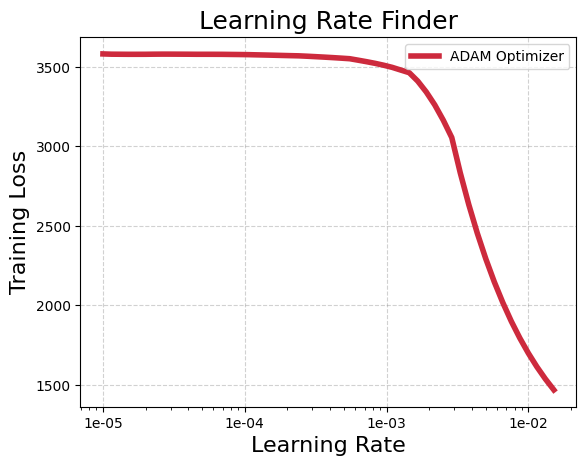

In [18]:
# Plot loss vs log-scaled learning rate
print ("\n   >> Optimal learning rate is where loss is decreasing at a rapid rate \n")
    
lr_finder.plot()